# Random Forest Classification

## 1. Veri Hazırlama ve Temizleme

Bu bölümde, gerekli Python kütüphaneleri yüklenir, veri seti okunur ve temizleme işlemleri uygulanır.  
Özetle:
- Eksik müşteri kimlikleri içeren satırlar kaldırılır.
- Toplam harcama hesaplanır.
- Geçersiz miktarlar filtrelenir.
- Fatura tarihleri datetime formatına dönüştürülür.
- Analiz için yıl-ay (YYYYMM) formatında ek bir sütun oluşturulur.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

# Veri Setini Yükleme
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url, sheet_name="Online Retail")

# Veri Temizleme
df = df.dropna(subset=["CustomerID"])
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df = df[df["Quantity"] > 0]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["YearMonth"] = df["InvoiceDate"].dt.year * 100 + df["InvoiceDate"].dt.month  # YYYYMM format

## 2. Özellik (Feature) Mühendisliği ve Churn Tanımlama

Bu bölümde, müşteri düzeyinde özet veriler oluşturulur.  
Özetle:
- Müşterilere ait toplam harcama, sipariş sayısı, ortalama sipariş değeri gibi metrikler hesaplanır.
- Her müşteri için benzersiz ülke sayısı, son satın alma tarihi ve son satın alma yıl-ay bilgileri belirlenir.
- Son 6 ay içerisinde alışveriş yapmayan müşteriler churn (müşteri kaybı) olarak tanımlanır.
- Kategorik veriler one-hot encoding yöntemiyle sayısal formata çevrilir.

In [ ]:
# Müşteri Düzeyinde Verileri Toplama
customer_data = df.groupby("CustomerID").agg(
    TotalSpend=("TotalPrice", "sum"),
    OrderCount=("InvoiceNo", "nunique"),
    AvgOrderValue=("TotalPrice", "mean"),
    UniqueCountries=("Country", "nunique"),
    LastPurchase=("InvoiceDate", "max"),
    LastPurchaseYM=("YearMonth", "max")  # Most recent purchase Year-Month
).reset_index()

# Churn Tanımlama
latest_date = df["InvoiceDate"].max()
customer_data["Churn"] = (latest_date - customer_data["LastPurchase"]).dt.days > 180
customer_data["Churn"] = customer_data["Churn"].astype(int)
customer_data = customer_data.drop(columns=["LastPurchase"])

# One-Hot Encode
customer_data = pd.get_dummies(customer_data, columns=["UniqueCountries", "LastPurchaseYM"], 
                                 prefix=["CountryCount", "YM"])

## 3. Model Eğitimi ve Optimizasyonu

Bu bölümde, makine öğrenmesi modeli için özellikler (features) ve hedef (target) belirlenir.  
Özetle:
- Müşteri verilerinden modelin eğitimi için kullanılacak özellikler ve hedef değişken tanımlanır.
- Sayısal özellikler standardizasyon işlemine tabi tutulur.
- Eğitim ve test verileri ayrılır.
- Random Forest modelinin hiperparametreleri için bir parametre ızgarası tanımlanır.
- RandomizedSearchCV kullanılarak en iyi hiperparametreler bulunur ve model eğitilir.

In [ ]:
# Makine Öğrenmesi için Features ve Target Tanımlama
X_clf = customer_data.drop(columns=["CustomerID", "Churn"])
y_clf = customer_data["Churn"]

# Sayısal Özelliklerin Standardizasyonu
numeric_features = ["TotalSpend", "OrderCount", "AvgOrderValue"]
scaler = StandardScaler()
X_clf[numeric_features] = scaler.fit_transform(X_clf[numeric_features])

# Eğitim ve Test Verilerinin Ayrılması
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Parametre Grid Tanımlama
param_grid_clf = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

# Rastgele Arama ile En İyi Parametrelerin Bulunması
rf_clf_opt = RandomForestClassifier(random_state=42)
random_search_clf = RandomizedSearchCV(rf_clf_opt, param_grid_clf, n_iter=20, cv=5, scoring="accuracy", random_state=42)
random_search_clf.fit(X_train_clf, y_train_clf)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [5, 10, 20, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=42, scoring='accuracy')

## 4. Model Değerlendirme ve Sonuçlar

Bu bölümde, optimize edilmiş model kullanılarak tahminler yapılır ve model performansı değerlendirilir.  
Özetle:
- En iyi model seçilerek test verileri üzerinde tahminler yapılır.
- Modelin doğruluk oranı, sınıflandırma raporu gibi metrikler hesaplanır.
- Önemli özelliklerin (feature) model içindeki katkıları görselleştirilir.
- Sınıflandırma (classification) ve regresyon (regression) arasındaki temel farklara değinilir;  
  sınıflandırma belirli sınıflara ayırırken, regresyon sürekli değişkenlerin tahmininde kullanılır.
- Bu model, tedarik zinciri yönetiminde müşteri kaybını öngörmek, kampanya stratejilerini optimize etmek gibi uygulamalarda kullanılabilir.

In [ ]:
# En İyi Modelin Seçilmesi
best_rf_clf = random_search_clf.best_estimator_
print("Best Hyperparameters:", random_search_clf.best_params_)

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}


In [ ]:
# Tahmin ve Değerlendirme
y_pred_best_clf = best_rf_clf.predict(X_test_clf)
accuracy_best = accuracy_score(y_test_clf, y_pred_best_clf)

print(f"Optimized Random Forest Classification Accuracy: {accuracy_best:.2%}")
print("Optimized Classification Report:\n", classification_report(y_test_clf, y_pred_best_clf))

Optimized Random Forest Classification Accuracy: 98.39%
Optimized Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       703
           1       1.00      0.92      0.96       165

    accuracy                           0.98       868
   macro avg       0.99      0.96      0.97       868
weighted avg       0.98      0.98      0.98       868



C:\Users\serko\AppData\Local\Temp\ipykernel_19740\1670280126.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_clf, palette="Greens_r")


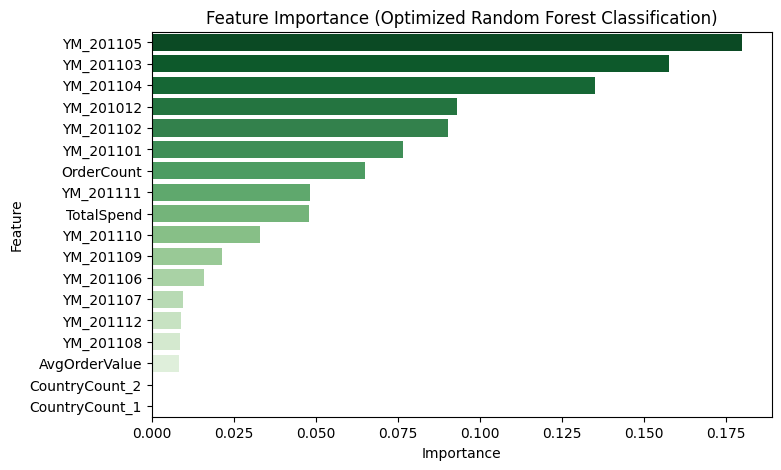

In [ ]:
# Önemli Özelliklerin Belirlenmesi ve Görselleştirilmesi
feature_importance_clf = pd.DataFrame({
    "Feature": X_clf.columns,
    "Importance": best_rf_clf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_clf, palette="Greens_r")
plt.title("Feature Importance (Optimized Random Forest Classification)")
plt.show()